In [ ]:
from data.ARCADE.dataloader import ARCADEDataset
from torch.utils.data import DataLoader
pathJson = 'data/ARCADE/processed/dataset.json'
dataset = ARCADEDataset(json_path=pathJson, split='train', task='Unsupervised')
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
for images in dataloader:
    print(f"Batch shape: {images.shape}")
    break


Batch shape: torch.Size([1, 1, 256, 256])


In [ ]:
from zoo.backbones import sanityCheck
sanityCheck()

ImportError: cannot import name 'sanityCheck' from 'zoo.backbones' (d:\Collateral Coronary Vessels XAI\zoo\backbones.py)

In [6]:
from zoo.models import SegmentatorCoronare
from zoo.backbones import get_backbone
model = SegmentatorCoronare(backbone='swinv2_tiny_window16_256', pretrained=False, in_channels=1)
import torch

print("SWIN")
model = SegmentatorCoronare(backbone='swinv2_tiny_window16_256', pretrained=False, in_channels=1)
dummy = torch.randn(2, 1, 256, 256)
out = model(dummy)
print(out.shape)
    
    
print('ConvNext')
model = SegmentatorCoronare(backbone='convnext_tiny', pretrained=False, in_channels=1)
dummy = torch.randn(2, 1, 256, 256)
out = model(dummy)
print(out.shape)
    
print('ViT')
model = SegmentatorCoronare(backbone='vit_small_patch16_224', pretrained=False, in_channels=1)
dummy = torch.randn(2, 1, 256, 256)
out = model(dummy)
print(out.shape)

ModuleNotFoundError: No module named 'backbones'

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from skimage.filters import frangi, gaussian, threshold_otsu
from skimage import exposure, morphology, measure
from skimage.measure import label, regionprops, block_reduce
from skimage.morphology import disk, reconstruction

import numpy as np
from skimage.filters import frangi, gaussian, threshold_otsu
from skimage import exposure, morphology
from skimage.measure import label, regionprops, block_reduce
from skimage.morphology import disk, reconstruction

def get_vasomim_probability_map(img):
    mask_roi = img > 0.05 
    mask_roi = morphology.binary_erosion(mask_roi, disk(15))
    
    img_clahe = exposure.equalize_adapthist(img, clip_limit=0.02, kernel_size=(32, 32))
    img_smooth = gaussian(img_clahe, sigma=1.0)

    scales_config = [
        {'sigma': 3.5, 'thresh_factor': 0.60}, 
        {'sigma': 2.0, 'thresh_factor': 0.45}  
    ]
    
    accumulated_mask = np.zeros_like(img, dtype=bool)
    accumulated_prob = np.zeros_like(img, dtype=float)

    for i, config in enumerate(scales_config):
        f_scale = frangi(img_smooth, sigmas=[config['sigma']], black_ridges=True, beta=0.5, gamma=2)
        f_scale = f_scale * mask_roi 
        
        if f_scale.max() > 0:
            f_scale = f_scale / f_scale.max()
            
        thresh = threshold_otsu(f_scale) if f_scale.max() > 0 else 0.1
        candidates = f_scale > (thresh * config['thresh_factor'])
        
        valid_layer = np.zeros_like(candidates)
        
        if i == 0:
            labels = label(candidates)
            if labels.max() > 0:
                regions = regionprops(labels)
                regions.sort(key=lambda x: x.area, reverse=True)
                
                largest = regions[0]
                valid_layer[labels == largest.label] = 1
                
                if len(regions) > 1 and regions[1].area > largest.area * 0.2:
                     valid_layer[labels == regions[1].label] = 1
        else:
            prev_dilated = morphology.binary_dilation(accumulated_mask, disk(4))
            seed = candidates & prev_dilated
            
            if seed.sum() > 0:
                valid_layer = reconstruction(seed, candidates, method='dilation').astype(bool)
                
        accumulated_mask = accumulated_mask | valid_layer.astype(bool)
        accumulated_prob = np.maximum(accumulated_prob, f_scale * valid_layer)

    PATCH_SIZE = 16
    
    final_prob_dilated = morphology.dilation(accumulated_prob, disk(2))
    patch_density = block_reduce(final_prob_dilated, block_size=(PATCH_SIZE, PATCH_SIZE), func=np.mean)
    
    h_p, w_p = patch_density.shape
    y, x = np.ogrid[:h_p, :w_p]
    center_bias = np.exp(-((x - w_p/2)**2 + (y - h_p/2)**2) / (2 * (w_p/2.5)**2))
    
    vasomim_probs = patch_density * center_bias
    vasomim_probs = (vasomim_probs - vasomim_probs.min()) / (vasomim_probs.max() - vasomim_probs.min() + 1e-6)
    vasomim_probs = vasomim_probs + 0.02 
    vasomim_probs = vasomim_probs / vasomim_probs.sum()

    return vasomim_probs.flatten()

In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from data.ARCADE.dataloader import ARCADEDataset
from torch.utils.data import DataLoader
from skimage.filters import frangi, gaussian, threshold_otsu
from skimage import exposure, morphology
from skimage.measure import label, regionprops
from skimage.morphology import disk, binary_closing, binary_opening, remove_small_objects, remove_small_holes

def get_vessel_segmentation(img):
    """
    Segmentare completă a vaselor coronariene folosind filtrul Frangi.
    Returnează mască binară la dimensiunea imaginii originale.
    """
    # 1. ROI mask
    mask_roi = img > 0.05 
    mask_roi = morphology.binary_erosion(mask_roi, disk(15))
    
    # 2. Pre-procesare îmbunătățită: Gaussian blur mai puternic + CLAHE
    img_blur = gaussian(img, sigma=1.5)  # Blur mai puternic pentru a conecta discontinuitățile
    img_clahe = exposure.equalize_adapthist(img_blur, clip_limit=0.03, kernel_size=(32, 32))
    
    # Smooth suplimentar după CLAHE
    img_smooth = gaussian(img_clahe, sigma=0.8)
    
    # 3. Aplică Frangi la scale multiple și mai dense
    scales_config = [
        {'sigma': 4.0, 'thresh_factor': 0.55},  # Vase foarte groase
        {'sigma': 3.0, 'thresh_factor': 0.58},  # Vase groase
        {'sigma': 2.2, 'thresh_factor': 0.48},  # Vase medii
        {'sigma': 1.5, 'thresh_factor': 0.42}   # Vase subțiri
    ]
    
    accumulated_mask = np.zeros_like(img, dtype=bool)
    
    for i, config in enumerate(scales_config):
        # Frangi filter cu parametri ajustați pentru continuitate
        f_scale = frangi(
            img_smooth, 
            sigmas=[config['sigma']], 
            black_ridges=True, 
            beta=0.5,   # Sensibilitate la structuri blob
            gamma=15    # Sensibilitate la contrast (mai mare = mai sensibil)
        )
        f_scale = f_scale * mask_roi 
        
        # Normalizare
        if f_scale.max() > 0:
            f_scale = f_scale / f_scale.max()
        
        # Threshold Otsu adaptat
        thresh = threshold_otsu(f_scale) if f_scale.max() > 0 else 0.1
        candidates = f_scale > (thresh * config['thresh_factor'])
        
        valid_layer = np.zeros_like(candidates)
        
        if i == 0:  # Prima scală: păstrează cele mai mari componente
            labels = label(candidates)
            if labels.max() > 0:
                regions = regionprops(labels)
                regions.sort(key=lambda x: x.area, reverse=True)
                
                # Păstrează cele mai mari 3 componente (pentru mai multe vase principale)
                for j, region in enumerate(regions[:3]):
                    if j == 0 or region.area > regions[0].area * 0.15:
                        valid_layer[labels == region.label] = 1
        else:  # Scale următoare: conectează cu anterioarele (dilatare mai agresivă)
            from skimage.morphology import reconstruction
            # Dilatare mai agresivă pentru a conecta mai bine
            prev_dilated = morphology.binary_dilation(accumulated_mask, disk(5))
            seed = candidates & prev_dilated
            
            if seed.sum() > 0:
                valid_layer = reconstruction(seed, candidates, method='dilation').astype(bool)
            else:
                # Dacă nu găsește seed, încearcă să adauge candidați din apropiere
                prev_dilated_more = morphology.binary_dilation(accumulated_mask, disk(8))
                seed = candidates & prev_dilated_more
                if seed.sum() > 0:
                    valid_layer = reconstruction(seed, candidates, method='dilation').astype(bool)
        
        accumulated_mask = accumulated_mask | valid_layer.astype(bool)
    
    # 4. Post-procesare mai agresivă pentru continuitate
    # Closing mai agresiv pentru a conecta întreruperile
    final_mask = binary_closing(accumulated_mask, disk(3))  # disk(3) în loc de disk(2)
    
    # Îndepărtare găuri mici
    final_mask = remove_small_holes(final_mask, area_threshold=300)
    
    # Opening mai ușor pentru a păstra detaliile
    final_mask = binary_opening(final_mask, disk(1))
    
    # Îndepărtare obiecte mici
    final_mask = remove_small_objects(final_mask, min_size=80)
    
    # Closing final pentru netezire
    final_mask = binary_closing(final_mask, disk(2))
    
    return final_mask.astype(np.uint8)


def generate_frangi_segmentations(num_patients=30, select_random=True, output_dir="VasoPlots"):
    """
    Generează segmentări Frangi pentru pacienții din train și le salvează.
    
    Args:
        num_patients: Număr de pacienți (None = toți)
        select_random: True = aleator, False = primii N
        output_dir: Folder unde se salvează imaginile
    """
    # Creează directorul de output
    os.makedirs(output_dir, exist_ok=True)
    
    # Încarcă datasetul
    pathJson = 'data/ARCADE/processed/dataset.json'
    dataset = ARCADEDataset(json_path=pathJson, split='train', task='Unsupervised')
    
    # Selectează indicii pacienților
    total_patients = len(dataset)
    if num_patients is None:
        num_patients = total_patients
    else:
        num_patients = min(num_patients, total_patients)
    
    if select_random:
        indices = random.sample(range(total_patients), num_patients)
    else:
        indices = list(range(num_patients))
    
    print(f"Procesare {num_patients} pacienți din {total_patients} totali...")
    
    # Procesează fiecare pacient
    for idx, patient_idx in enumerate(indices):
        # Obține imaginea
        img_tensor = dataset[patient_idx]
        img = img_tensor.squeeze().numpy()  # [256, 256]
        
        # Aplică segmentarea Frangi
        try:
            segmentation = get_vessel_segmentation(img)
            
        except Exception as e:
            print(f"Eroare la pacientul {patient_idx}: {e}")
            import traceback
            traceback.print_exc()
            continue
        
        # Creează figura cu 3 coloane
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        # Coloana 1: Imaginea originală
        axes[0].imshow(img, cmap='gray')
        axes[0].set_title('Imagine Originală')
        axes[0].axis('off')
        
        # Coloana 2: Segmentarea Frangi
        axes[1].imshow(segmentation, cmap='gray')
        axes[1].set_title('Segmentare Frangi')
        axes[1].axis('off')
        
        # Coloana 3: Overlay
        axes[2].imshow(img, cmap='gray')
        axes[2].imshow(segmentation, cmap='Reds', alpha=0.5)
        axes[2].set_title('Overlay')
        axes[2].axis('off')
        
        # Salvează figura
        output_path = os.path.join(output_dir, f'patient_{idx:03d}.png')
        plt.tight_layout()
        plt.savefig(output_path, dpi=150, bbox_inches='tight')
        plt.close()
        
        if (idx + 1) % 10 == 0:
            print(f"Procesat {idx + 1}/{num_patients} pacienți...")
    
    print(f"✓ Finalizat! Salvat în {output_dir}/")

# Rulează funcția
generate_frangi_segmentations(num_patients=30, select_random=True)

Procesare 30 pacienți din 1997 totali...


C:\Users\alexb\AppData\Local\Temp\ipykernel_15796\2367773794.py:20: FutureWarning: `binary_erosion` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.erosion` instead. Note the pixel shift by 1 for even-sized footprints (see docstring notes).
  mask_roi = morphology.binary_erosion(mask_roi, disk(15))
C:\Users\alexb\AppData\Local\Temp\ipykernel_15796\2367773794.py:63: FutureWarning: `binary_dilation` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.dilation` instead. Note the lack of mirroring for non-symmetric footprints (see docstring notes).
  prev_dilated = morphology.binary_dilation(accumulated_mask, disk(4))
C:\Users\alexb\AppData\Local\Temp\ipykernel_15796\2367773794.py:72: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  final_mask = binary_closing(accumulated_mask, disk(2))
C:\Users\alexb\AppDat

Procesat 10/30 pacienți...


C:\Users\alexb\AppData\Local\Temp\ipykernel_15796\2367773794.py:20: FutureWarning: `binary_erosion` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.erosion` instead. Note the pixel shift by 1 for even-sized footprints (see docstring notes).
  mask_roi = morphology.binary_erosion(mask_roi, disk(15))
C:\Users\alexb\AppData\Local\Temp\ipykernel_15796\2367773794.py:63: FutureWarning: `binary_dilation` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.dilation` instead. Note the lack of mirroring for non-symmetric footprints (see docstring notes).
  prev_dilated = morphology.binary_dilation(accumulated_mask, disk(4))
C:\Users\alexb\AppData\Local\Temp\ipykernel_15796\2367773794.py:72: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  final_mask = binary_closing(accumulated_mask, disk(2))
C:\Users\alexb\AppDat

Procesat 20/30 pacienți...


C:\Users\alexb\AppData\Local\Temp\ipykernel_15796\2367773794.py:20: FutureWarning: `binary_erosion` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.erosion` instead. Note the pixel shift by 1 for even-sized footprints (see docstring notes).
  mask_roi = morphology.binary_erosion(mask_roi, disk(15))
C:\Users\alexb\AppData\Local\Temp\ipykernel_15796\2367773794.py:63: FutureWarning: `binary_dilation` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.dilation` instead. Note the lack of mirroring for non-symmetric footprints (see docstring notes).
  prev_dilated = morphology.binary_dilation(accumulated_mask, disk(4))
C:\Users\alexb\AppData\Local\Temp\ipykernel_15796\2367773794.py:72: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  final_mask = binary_closing(accumulated_mask, disk(2))
C:\Users\alexb\AppDat

Procesat 30/30 pacienți...
✓ Finalizat! Salvat în VasoPlots/


In [3]:
import timm

print(timm.list_models(pretrained=False))

c:\Users\alexb\AppData\Local\Programs\Python\Python314\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


AttributeError: module 'torch' has no attribute '_utils'

🔍 Găsite 1997 măști în vasomim_masks_only
📊 Parametri: border=30px, area_thresh=500, tree_ratio=0.15
------------------------------------------------------------
✅ [1/1997] patient_000.png: 3322 → 3322 pixeli (-0.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:14: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will b

✅ [2/1997] patient_001.png: 3642 → 2406 pixeli (-33.9%)
✅ [3/1997] patient_002.png: 5173 → 5173 pixeli (-0.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will b

✅ [4/1997] patient_003.png: 7480 → 5794 pixeli (-22.5%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)


✅ [5/1997] patient_004.png: 2743 → 2743 pixeli (-0.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)


✅ [6/1997] patient_005.png: 5032 → 2848 pixeli (-43.4%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)


✅ [7/1997] patient_006.png: 3565 → 3565 pixeli (-0.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)


✅ [8/1997] patient_007.png: 1911 → 1911 pixeli (-0.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:14: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if region.minor_axis_length < 6:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value,

✅ [9/1997] patient_008.png: 4569 → 3382 pixeli (-26.0%)
✅ [10/1997] patient_009.png: 4843 → 4019 pixeli (-17.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will b

✅ [11/1997] patient_010.png: 2676 → 0 pixeli (-100.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)


✅ [12/1997] patient_011.png: 6461 → 4734 pixeli (-26.7%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)


✅ [13/1997] patient_012.png: 4968 → 3051 pixeli (-38.6%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)
c:\Users\alexb\AppData\Local\Programs\Python\Python314\Lib\site-packages\skimage\_shared\utils.py:386: UserWarning: vasomim_masks_clean\patient_013_clean.png is a low c

✅ [14/1997] patient_013.png: 1877 → 0 pixeli (-100.0%)
✅ [15/1997] patient_014.png: 3580 → 3580 pixeli (-0.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:14: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will b

✅ [16/1997] patient_015.png: 6551 → 5298 pixeli (-19.1%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:14: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if region.minor_axis_length < 6:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value,

✅ [17/1997] patient_016.png: 5175 → 3015 pixeli (-41.7%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)
c:\Users\alexb\AppData\Local\Programs\Python\Python314\Lib\site-packages\skimage\_shared\utils.py:386: UserWarning: vasomim_masks_clean\patient_017_clean.png is a low c

✅ [18/1997] patient_017.png: 1985 → 0 pixeli (-100.0%)
✅ [19/1997] patient_018.png: 1982 → 1584 pixeli (-20.1%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will b

✅ [20/1997] patient_019.png: 3112 → 2119 pixeli (-31.9%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)


✅ [21/1997] patient_020.png: 3775 → 3490 pixeli (-7.5%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:14: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if region.minor_axis_length < 6:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value,

✅ [22/1997] patient_021.png: 4325 → 3460 pixeli (-20.0%)
✅ [23/1997] patient_022.png: 3017 → 1810 pixeli (-40.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:14: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if region.minor_axis_length < 6:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value,

✅ [24/1997] patient_023.png: 7196 → 7196 pixeli (-0.0%)
✅ [25/1997] patient_024.png: 5666 → 5666 pixeli (-0.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)


✅ [26/1997] patient_025.png: 3357 → 2682 pixeli (-20.1%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)


✅ [27/1997] patient_026.png: 6716 → 6716 pixeli (-0.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)


✅ [28/1997] patient_027.png: 4251 → 3080 pixeli (-27.5%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:14: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if region.minor_axis_length < 6:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value,

✅ [29/1997] patient_028.png: 5833 → 4833 pixeli (-17.1%)
✅ [30/1997] patient_029.png: 5155 → 5155 pixeli (-0.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will b

✅ [31/1997] patient_030.png: 4977 → 2725 pixeli (-45.2%)
✅ [32/1997] patient_031.png: 2721 → 2721 pixeli (-0.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)


✅ [33/1997] patient_032.png: 5714 → 3186 pixeli (-44.2%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)
c:\Users\alexb\AppData\Local\Programs\Python\Python314\Lib\site-packages\skimage\_shared\utils.py:386: UserWarning: vasomim_masks_clean\patient_033_clean.png is a low c

✅ [34/1997] patient_033.png: 3682 → 0 pixeli (-100.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)
c:\Users\alexb\AppData\Local\Programs\Python\Python314\Lib\site-packages\skimage\_shared\utils.py:386: UserWarning: vasomim_masks_clean\patient_034_clean.png is a low c

✅ [35/1997] patient_034.png: 1252 → 0 pixeli (-100.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:14: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if region.minor_axis_length < 6:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value,

✅ [36/1997] patient_035.png: 4222 → 0 pixeli (-100.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)
c:\Users\alexb\AppData\Local\Programs\Python\Python314\Lib\site-packages\skimage\_shared\utils.py:386: UserWarning: vasomim_masks_clean\patient_036_clean.png is a low c

✅ [37/1997] patient_036.png: 2769 → 0 pixeli (-100.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)


✅ [38/1997] patient_037.png: 3617 → 3617 pixeli (-0.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)


✅ [39/1997] patient_038.png: 2152 → 2152 pixeli (-0.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:14: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if region.minor_axis_length < 6:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value,

✅ [40/1997] patient_039.png: 3660 → 2379 pixeli (-35.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)
c:\Users\alexb\AppData\Local\Programs\Python\Python314\Lib\site-packages\skimage\_shared\utils.py:386: UserWarning: vasomim_masks_clean\patient_040_clean.png is a low c

✅ [41/1997] patient_040.png: 1536 → 0 pixeli (-100.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)


✅ [42/1997] patient_041.png: 2505 → 2505 pixeli (-0.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:14: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if region.minor_axis_length < 6:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value,

✅ [43/1997] patient_042.png: 5819 → 3195 pixeli (-45.1%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)
c:\Users\alexb\AppData\Local\Programs\Python\Python314\Lib\site-packages\skimage\_shared\utils.py:386: UserWarning: vasomim_masks_clean\patient_043_clean.png is a low c

✅ [44/1997] patient_043.png: 2636 → 0 pixeli (-100.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)


✅ [45/1997] patient_044.png: 4753 → 4753 pixeli (-0.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)


✅ [46/1997] patient_045.png: 5503 → 3503 pixeli (-36.3%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)


✅ [47/1997] patient_046.png: 2804 → 2804 pixeli (-0.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:14: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if region.minor_axis_length < 6:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value,

✅ [48/1997] patient_047.png: 3960 → 2759 pixeli (-30.3%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)


✅ [49/1997] patient_048.png: 6889 → 4839 pixeli (-29.8%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:14: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if region.minor_axis_length < 6:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value,

✅ [50/1997] patient_049.png: 3899 → 3899 pixeli (-0.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)


✅ [51/1997] patient_050.png: 3716 → 3716 pixeli (-0.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)


✅ [52/1997] patient_051.png: 4472 → 2661 pixeli (-40.5%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)


✅ [53/1997] patient_052.png: 5821 → 3524 pixeli (-39.5%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)


✅ [54/1997] patient_053.png: 5951 → 5951 pixeli (-0.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)
c:\Users\alexb\AppData\Local\Programs\Python\Python314\Lib\site-packages\skimage\_shared\utils.py:386: UserWarning: vasomim_masks_clean\patient_054_clean.png is a low c

✅ [55/1997] patient_054.png: 2903 → 0 pixeli (-100.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)
c:\Users\alexb\AppData\Local\Programs\Python\Python314\Lib\site-packages\skimage\_shared\utils.py:386: UserWarning: vasomim_masks_clean\patient_055_clean.png is a low c

✅ [56/1997] patient_055.png: 3008 → 0 pixeli (-100.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:14: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if region.minor_axis_length < 6:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value,

✅ [57/1997] patient_056.png: 4588 → 758 pixeli (-83.5%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)
c:\Users\alexb\AppData\Local\Programs\Python\Python314\Lib\site-packages\skimage\_shared\utils.py:386: UserWarning: vasomim_masks_clean\patient_057_clean.png is a low c

✅ [58/1997] patient_057.png: 4250 → 0 pixeli (-100.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)


✅ [59/1997] patient_058.png: 2611 → 1213 pixeli (-53.5%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)
c:\Users\alexb\AppData\Local\Programs\Python\Python314\Lib\site-packages\skimage\_shared\utils.py:386: UserWarning: vasomim_masks_clean\patient_059_clean.png is a low c

✅ [60/1997] patient_059.png: 4566 → 0 pixeli (-100.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)
c:\Users\alexb\AppData\Local\Programs\Python\Python314\Lib\site-packages\skimage\_shared\utils.py:386: UserWarning: vasomim_masks_clean\patient_060_clean.png is a low c

✅ [61/1997] patient_060.png: 3915 → 0 pixeli (-100.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)


✅ [62/1997] patient_061.png: 5704 → 3389 pixeli (-40.6%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)


✅ [63/1997] patient_062.png: 2071 → 1779 pixeli (-14.1%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)


✅ [64/1997] patient_063.png: 3226 → 2693 pixeli (-16.5%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)


✅ [65/1997] patient_064.png: 8225 → 5495 pixeli (-33.2%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)


✅ [66/1997] patient_065.png: 6196 → 6196 pixeli (-0.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)


✅ [67/1997] patient_066.png: 2862 → 2248 pixeli (-21.5%)
✅ [68/1997] patient_067.png: 4860 → 4860 pixeli (-0.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will b

✅ [69/1997] patient_068.png: 4555 → 0 pixeli (-100.0%)
✅ [70/1997] patient_069.png: 4850 → 4850 pixeli (-0.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will b

✅ [71/1997] patient_070.png: 3050 → 3050 pixeli (-0.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)


✅ [72/1997] patient_071.png: 5502 → 5502 pixeli (-0.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)


✅ [73/1997] patient_072.png: 3632 → 3632 pixeli (-0.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:14: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if region.minor_axis_length < 6:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value,

✅ [74/1997] patient_073.png: 5839 → 4626 pixeli (-20.8%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)


✅ [75/1997] patient_074.png: 2920 → 2920 pixeli (-0.0%)
✅ [76/1997] patient_075.png: 2876 → 2132 pixeli (-25.9%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will b

✅ [77/1997] patient_076.png: 2947 → 0 pixeli (-100.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)


✅ [78/1997] patient_077.png: 4167 → 4167 pixeli (-0.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:14: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if region.minor_axis_length < 6:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value,

✅ [79/1997] patient_078.png: 5437 → 3947 pixeli (-27.4%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)


✅ [80/1997] patient_079.png: 3973 → 3076 pixeli (-22.6%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)


✅ [81/1997] patient_080.png: 2579 → 2110 pixeli (-18.2%)
✅ [82/1997] patient_081.png: 4310 → 4310 pixeli (-0.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:14: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will b

✅ [83/1997] patient_082.png: 4308 → 2823 pixeli (-34.5%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:14: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if region.minor_axis_length < 6:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value,

✅ [84/1997] patient_083.png: 6877 → 3450 pixeli (-49.8%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)


✅ [85/1997] patient_084.png: 4934 → 2643 pixeli (-46.4%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)


✅ [86/1997] patient_085.png: 4014 → 3475 pixeli (-13.4%)
✅ [87/1997] patient_086.png: 5238 → 5238 pixeli (-0.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will b

✅ [88/1997] patient_087.png: 4343 → 1227 pixeli (-71.7%)
✅ [89/1997] patient_088.png: 5560 → 5560 pixeli (-0.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will b

✅ [90/1997] patient_089.png: 4540 → 4540 pixeli (-0.0%)
✅ [91/1997] patient_090.png: 5374 → 4095 pixeli (-23.8%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:14: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if region.minor_axis_length < 6:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value,

✅ [92/1997] patient_091.png: 4387 → 0 pixeli (-100.0%)
✅ [93/1997] patient_092.png: 4002 → 1018 pixeli (-74.6%)
✅ [94/1997] patient_093.png: 1941 → 496 pixeli (-74.4%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)
c:\Users\alexb\AppData\Local\Programs\Python\Python314\Lib\site-packages\skimage\_shared\utils.py:386: UserWarning: vasomim_masks_clean\patient_093_clean.png is a low c

✅ [95/1997] patient_094.png: 7095 → 3911 pixeli (-44.9%)
✅ [96/1997] patient_095.png: 1799 → 0 pixeli (-100.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)
c:\Users\alexb\AppData\Local\Programs\Python\Python314\Lib\site-packages\skimage\_shared\utils.py:386: UserWarning: vasomim_masks_clean\patient_095_clean.png is a low c

✅ [97/1997] patient_096.png: 3213 → 3213 pixeli (-0.0%)
✅ [98/1997] patient_097.png: 3720 → 0 pixeli (-100.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)
c:\Users\alexb\AppData\Local\Programs\Python\Python314\Lib\site-packages\skimage\_shared\utils.py:386: UserWarning: vasomim_masks_clean\patient_097_clean.png is a low c

✅ [99/1997] patient_098.png: 2104 → 590 pixeli (-72.0%)
✅ [100/1997] patient_099.png: 3082 → 0 pixeli (-100.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)
c:\Users\alexb\AppData\Local\Programs\Python\Python314\Lib\site-packages\skimage\_shared\utils.py:386: UserWarning: vasomim_masks_clean\patient_099_clean.png is a low c

✅ [101/1997] patient_100.png: 5738 → 1822 pixeli (-68.2%)
✅ [102/1997] patient_1000.png: 2002 → 2002 pixeli (-0.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will b

✅ [103/1997] patient_1001.png: 2343 → 0 pixeli (-100.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)
c:\Users\alexb\AppData\Local\Programs\Python\Python314\Lib\site-packages\skimage\_shared\utils.py:386: UserWarning: vasomim_masks_clean\patient_1002_clean.png is a low 

✅ [104/1997] patient_1002.png: 2638 → 0 pixeli (-100.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)


✅ [105/1997] patient_1003.png: 2533 → 2533 pixeli (-0.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:14: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if region.minor_axis_length < 6:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value,

✅ [106/1997] patient_1004.png: 2734 → 0 pixeli (-100.0%)
✅ [107/1997] patient_1005.png: 2340 → 0 pixeli (-100.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)
c:\Users\alexb\AppData\Local\Programs\Python\Python314\Lib\site-packages\skimage\_shared\utils.py:386: UserWarning: vasomim_masks_clean\patient_1005_clean.png is a low 

✅ [108/1997] patient_1006.png: 2694 → 1933 pixeli (-28.2%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)


✅ [109/1997] patient_1007.png: 4201 → 4201 pixeli (-0.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:14: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if region.minor_axis_length < 6:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value,

✅ [110/1997] patient_1008.png: 3899 → 3899 pixeli (-0.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)


✅ [111/1997] patient_1009.png: 3865 → 3865 pixeli (-0.0%)
✅ [112/1997] patient_101.png: 3981 → 3981 pixeli (-0.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will b

✅ [113/1997] patient_1010.png: 2547 → 2547 pixeli (-0.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)


✅ [114/1997] patient_1011.png: 5233 → 2274 pixeli (-56.5%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)


✅ [115/1997] patient_1012.png: 5600 → 4118 pixeli (-26.5%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)


✅ [116/1997] patient_1013.png: 3888 → 3888 pixeli (-0.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)
c:\Users\alexb\AppData\Local\Programs\Python\Python314\Lib\site-packages\skimage\_shared\utils.py:386: UserWarning: vasomim_masks_clean\patient_1014_clean.png is a low 

✅ [117/1997] patient_1014.png: 2990 → 0 pixeli (-100.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)


✅ [118/1997] patient_1015.png: 3099 → 3099 pixeli (-0.0%)
✅ [119/1997] patient_1016.png: 7421 → 5731 pixeli (-22.8%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:14: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will b

✅ [120/1997] patient_1017.png: 4221 → 2911 pixeli (-31.0%)
✅ [121/1997] patient_1018.png: 4881 → 4881 pixeli (-0.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will b

✅ [122/1997] patient_1019.png: 3676 → 3676 pixeli (-0.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)
c:\Users\alexb\AppData\Local\Programs\Python\Python314\Lib\site-packages\skimage\_shared\utils.py:386: UserWarning: vasomim_masks_clean\patient_102_clean.png is a low c

✅ [123/1997] patient_102.png: 6465 → 0 pixeli (-100.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)


✅ [124/1997] patient_1020.png: 2053 → 2053 pixeli (-0.0%)
✅ [125/1997] patient_1021.png: 2654 → 2654 pixeli (-0.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will b

✅ [126/1997] patient_1022.png: 5176 → 5176 pixeli (-0.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)


✅ [127/1997] patient_1023.png: 2696 → 2696 pixeli (-0.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)
c:\Users\alexb\AppData\Local\Programs\Python\Python314\Lib\site-packages\skimage\_shared\utils.py:386: UserWarning: vasomim_masks_clean\patient_1024_clean.png is a low 

✅ [128/1997] patient_1024.png: 2548 → 0 pixeli (-100.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)
c:\Users\alexb\AppData\Local\Programs\Python\Python314\Lib\site-packages\skimage\_shared\utils.py:386: UserWarning: vasomim_masks_clean\patient_1025_clean.png is a low 

✅ [129/1997] patient_1025.png: 2104 → 590 pixeli (-72.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)
c:\Users\alexb\AppData\Local\Programs\Python\Python314\Lib\site-packages\skimage\_shared\utils.py:386: UserWarning: vasomim_masks_clean\patient_1026_clean.png is a low 

✅ [130/1997] patient_1026.png: 5255 → 0 pixeli (-100.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:14: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if region.minor_axis_length < 6:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value,

✅ [131/1997] patient_1027.png: 4999 → 0 pixeli (-100.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)


✅ [132/1997] patient_1028.png: 3081 → 3081 pixeli (-0.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)


✅ [133/1997] patient_1029.png: 3160 → 3160 pixeli (-0.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)


✅ [134/1997] patient_103.png: 2537 → 680 pixeli (-73.2%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)
c:\Users\alexb\AppData\Local\Programs\Python\Python314\Lib\site-packages\skimage\_shared\utils.py:386: UserWarning: vasomim_masks_clean\patient_1030_clean.png is a low 

✅ [135/1997] patient_1030.png: 2859 → 0 pixeli (-100.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:14: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if region.minor_axis_length < 6:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value,

✅ [136/1997] patient_1031.png: 4437 → 3312 pixeli (-25.4%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)


✅ [137/1997] patient_1032.png: 3404 → 1809 pixeli (-46.9%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:14: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if region.minor_axis_length < 6:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value,

✅ [138/1997] patient_1033.png: 2511 → 0 pixeli (-100.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)


✅ [139/1997] patient_1034.png: 2997 → 2539 pixeli (-15.3%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)


✅ [140/1997] patient_1035.png: 3555 → 3555 pixeli (-0.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)
c:\Users\alexb\AppData\Local\Programs\Python\Python314\Lib\site-packages\skimage\_shared\utils.py:386: UserWarning: vasomim_masks_clean\patient_1036_clean.png is a low 

✅ [141/1997] patient_1036.png: 3572 → 0 pixeli (-100.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:14: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if region.minor_axis_length < 6:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value,

✅ [142/1997] patient_1037.png: 4644 → 3384 pixeli (-27.1%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:14: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if region.minor_axis_length < 6:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value,

✅ [143/1997] patient_1038.png: 5576 → 4346 pixeli (-22.1%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:14: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if region.minor_axis_length < 6:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value,

✅ [144/1997] patient_1039.png: 5294 → 2607 pixeli (-50.8%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)


✅ [145/1997] patient_104.png: 2415 → 2415 pixeli (-0.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:14: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if region.minor_axis_length < 6:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value,

✅ [146/1997] patient_1040.png: 4614 → 3421 pixeli (-25.9%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)


✅ [147/1997] patient_1041.png: 6328 → 4726 pixeli (-25.3%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)


✅ [148/1997] patient_1042.png: 4628 → 3037 pixeli (-34.4%)
✅ [149/1997] patient_1043.png: 3753 → 2841 pixeli (-24.3%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:14: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if region.minor_axis_length < 6:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value,

✅ [150/1997] patient_1044.png: 4932 → 4932 pixeli (-0.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)
c:\Users\alexb\AppData\Local\Programs\Python\Python314\Lib\site-packages\skimage\_shared\utils.py:386: UserWarning: vasomim_masks_clean\patient_1045_clean.png is a low 

✅ [151/1997] patient_1045.png: 1911 → 0 pixeli (-100.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)
c:\Users\alexb\AppData\Local\Programs\Python\Python314\Lib\site-packages\skimage\_shared\utils.py:386: UserWarning: vasomim_masks_clean\patient_1046_clean.png is a low 

✅ [152/1997] patient_1046.png: 3010 → 0 pixeli (-100.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)
c:\Users\alexb\AppData\Local\Programs\Python\Python314\Lib\site-packages\skimage\_shared\utils.py:386: UserWarning: vasomim_masks_clean\patient_1047_clean.png is a low 

✅ [153/1997] patient_1047.png: 4638 → 0 pixeli (-100.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)


✅ [154/1997] patient_1048.png: 2981 → 2981 pixeli (-0.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)


✅ [155/1997] patient_1049.png: 1857 → 1857 pixeli (-0.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)


✅ [156/1997] patient_105.png: 4591 → 2685 pixeli (-41.5%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)
c:\Users\alexb\AppData\Local\Programs\Python\Python314\Lib\site-packages\skimage\_shared\utils.py:386: UserWarning: vasomim_masks_clean\patient_1050_clean.png is a low 

✅ [157/1997] patient_1050.png: 948 → 0 pixeli (-100.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)


✅ [158/1997] patient_1051.png: 2882 → 2882 pixeli (-0.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)


✅ [159/1997] patient_1052.png: 5439 → 5439 pixeli (-0.0%)
✅ [160/1997] patient_1053.png: 4352 → 4352 pixeli (-0.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will b

✅ [161/1997] patient_1054.png: 4656 → 4656 pixeli (-0.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)


✅ [162/1997] patient_1055.png: 2437 → 1936 pixeli (-20.6%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)


✅ [163/1997] patient_1056.png: 3826 → 3826 pixeli (-0.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)
c:\Users\alexb\AppData\Local\Programs\Python\Python314\Lib\site-packages\skimage\_shared\utils.py:386: UserWarning: vasomim_masks_clean\patient_1057_clean.png is a low 

✅ [164/1997] patient_1057.png: 1988 → 0 pixeli (-100.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)
c:\Users\alexb\AppData\Local\Programs\Python\Python314\Lib\site-packages\skimage\_shared\utils.py:386: UserWarning: vasomim_masks_clean\patient_1058_clean.png is a low 

✅ [165/1997] patient_1058.png: 1845 → 0 pixeli (-100.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)


✅ [166/1997] patient_1059.png: 2982 → 2982 pixeli (-0.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)


✅ [167/1997] patient_106.png: 4618 → 738 pixeli (-84.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)


✅ [168/1997] patient_1060.png: 3176 → 3176 pixeli (-0.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)
c:\Users\alexb\AppData\Local\Programs\Python\Python314\Lib\site-packages\skimage\_shared\utils.py:386: UserWarning: vasomim_masks_clean\patient_1061_clean.png is a low 

✅ [169/1997] patient_1061.png: 2396 → 0 pixeli (-100.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)
c:\Users\alexb\AppData\Local\Programs\Python\Python314\Lib\site-packages\skimage\_shared\utils.py:386: UserWarning: vasomim_masks_clean\patient_1062_clean.png is a low 

✅ [170/1997] patient_1062.png: 4129 → 0 pixeli (-100.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:14: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if region.minor_axis_length < 6:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value,

✅ [171/1997] patient_1063.png: 5144 → 2984 pixeli (-42.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)
c:\Users\alexb\AppData\Local\Programs\Python\Python314\Lib\site-packages\skimage\_shared\utils.py:386: UserWarning: vasomim_masks_clean\patient_1064_clean.png is a low 

✅ [172/1997] patient_1064.png: 4362 → 0 pixeli (-100.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)


✅ [173/1997] patient_1065.png: 6858 → 4347 pixeli (-36.6%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:14: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if region.minor_axis_length < 6:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value,

✅ [174/1997] patient_1066.png: 6374 → 0 pixeli (-100.0%)
✅ [175/1997] patient_1067.png: 4725 → 4725 pixeli (-0.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will b

✅ [176/1997] patient_1068.png: 5013 → 5013 pixeli (-0.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:14: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if region.minor_axis_length < 6:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value,

✅ [177/1997] patient_1069.png: 2369 → 1886 pixeli (-20.4%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)


✅ [178/1997] patient_107.png: 5330 → 5330 pixeli (-0.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)


✅ [179/1997] patient_1070.png: 2648 → 2111 pixeli (-20.3%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:14: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if region.minor_axis_length < 6:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value,

✅ [180/1997] patient_1071.png: 3103 → 0 pixeli (-100.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)
c:\Users\alexb\AppData\Local\Programs\Python\Python314\Lib\site-packages\skimage\_shared\utils.py:386: UserWarning: vasomim_masks_clean\patient_1072_clean.png is a low 

✅ [181/1997] patient_1072.png: 4555 → 0 pixeli (-100.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)


✅ [182/1997] patient_1073.png: 4489 → 4489 pixeli (-0.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)


✅ [183/1997] patient_1074.png: 4219 → 3401 pixeli (-19.4%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)


✅ [184/1997] patient_1075.png: 3631 → 3631 pixeli (-0.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)
c:\Users\alexb\AppData\Local\Programs\Python\Python314\Lib\site-packages\skimage\_shared\utils.py:386: UserWarning: vasomim_masks_clean\patient_1076_clean.png is a low 

✅ [185/1997] patient_1076.png: 3237 → 0 pixeli (-100.0%)
✅ [186/1997] patient_1077.png: 1814 → 0 pixeli (-100.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)
c:\Users\alexb\AppData\Local\Programs\Python\Python314\Lib\site-packages\skimage\_shared\utils.py:386: UserWarning: vasomim_masks_clean\patient_1077_clean.png is a low 

✅ [187/1997] patient_1078.png: 2148 → 2148 pixeli (-0.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)


✅ [188/1997] patient_1079.png: 5579 → 5579 pixeli (-0.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)


✅ [189/1997] patient_108.png: 5103 → 5103 pixeli (-0.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)


✅ [190/1997] patient_1080.png: 4896 → 4896 pixeli (-0.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:14: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if region.minor_axis_length < 6:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value,

✅ [191/1997] patient_1081.png: 2888 → 2460 pixeli (-14.8%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)


✅ [192/1997] patient_1082.png: 4129 → 4129 pixeli (-0.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)
c:\Users\alexb\AppData\Local\Programs\Python\Python314\Lib\site-packages\skimage\_shared\utils.py:386: UserWarning: vasomim_masks_clean\patient_1083_clean.png is a low 

✅ [193/1997] patient_1083.png: 1847 → 0 pixeli (-100.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:14: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if region.minor_axis_length < 6:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value,

✅ [194/1997] patient_1084.png: 3666 → 2401 pixeli (-34.5%)
✅ [195/1997] patient_1085.png: 3018 → 1812 pixeli (-40.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:14: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if region.minor_axis_length < 6:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value,

✅ [196/1997] patient_1086.png: 5716 → 5716 pixeli (-0.0%)
✅ [197/1997] patient_1087.png: 5004 → 3659 pixeli (-26.9%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:14: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if region.minor_axis_length < 6:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value,

✅ [198/1997] patient_1088.png: 2265 → 1956 pixeli (-13.6%)
✅ [199/1997] patient_1089.png: 1927 → 0 pixeli (-100.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)
c:\Users\alexb\AppData\Local\Programs\Python\Python314\Lib\site-packages\skimage\_shared\utils.py:386: UserWarning: vasomim_masks_clean\patient_1089_clean.png is a low 

✅ [200/1997] patient_109.png: 2411 → 346 pixeli (-85.6%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)


✅ [201/1997] patient_1090.png: 4012 → 4012 pixeli (-0.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:14: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if region.minor_axis_length < 6:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value,

✅ [202/1997] patient_1091.png: 5814 → 4812 pixeli (-17.2%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)
c:\Users\alexb\AppData\Local\Programs\Python\Python314\Lib\site-packages\skimage\_shared\utils.py:386: UserWarning: vasomim_masks_clean\patient_1092_clean.png is a low 

✅ [203/1997] patient_1092.png: 3813 → 0 pixeli (-100.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)


✅ [204/1997] patient_1093.png: 5980 → 5980 pixeli (-0.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)


✅ [205/1997] patient_1094.png: 3553 → 3553 pixeli (-0.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)


✅ [206/1997] patient_1095.png: 4290 → 4290 pixeli (-0.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)


✅ [207/1997] patient_1096.png: 2697 → 2697 pixeli (-0.0%)
✅ [208/1997] patient_1097.png: 1792 → 1521 pixeli (-15.1%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will b

✅ [209/1997] patient_1098.png: 2064 → 2064 pixeli (-0.0%)
✅ [210/1997] patient_1099.png: 2106 → 2106 pixeli (-0.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will b

✅ [211/1997] patient_110.png: 2636 → 0 pixeli (-100.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)
c:\Users\alexb\AppData\Local\Programs\Python\Python314\Lib\site-packages\skimage\_shared\utils.py:386: UserWarning: vasomim_masks_clean\patient_1100_clean.png is a low 

✅ [212/1997] patient_1100.png: 3301 → 0 pixeli (-100.0%)
✅ [213/1997] patient_1101.png: 3577 → 3577 pixeli (-0.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will b

✅ [214/1997] patient_1102.png: 1643 → 1213 pixeli (-26.2%)
✅ [215/1997] patient_1103.png: 1861 → 1861 pixeli (-0.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will b

✅ [216/1997] patient_1104.png: 4092 → 4092 pixeli (-0.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)


✅ [217/1997] patient_1105.png: 5521 → 5521 pixeli (-0.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)


✅ [218/1997] patient_1106.png: 4108 → 4108 pixeli (-0.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)


✅ [219/1997] patient_1107.png: 3329 → 3329 pixeli (-0.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)


✅ [220/1997] patient_1108.png: 2127 → 967 pixeli (-54.5%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)


✅ [221/1997] patient_1109.png: 5065 → 4513 pixeli (-10.9%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)


✅ [222/1997] patient_111.png: 4093 → 4093 pixeli (-0.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)


✅ [223/1997] patient_1110.png: 2637 → 2637 pixeli (-0.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)


✅ [224/1997] patient_1111.png: 5774 → 3234 pixeli (-44.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)
c:\Users\alexb\AppData\Local\Programs\Python\Python314\Lib\site-packages\skimage\_shared\utils.py:386: UserWarning: vasomim_masks_clean\patient_1112_clean.png is a low 

✅ [225/1997] patient_1112.png: 3622 → 0 pixeli (-100.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)
c:\Users\alexb\AppData\Local\Programs\Python\Python314\Lib\site-packages\skimage\_shared\utils.py:386: UserWarning: vasomim_masks_clean\patient_1113_clean.png is a low 

✅ [226/1997] patient_1113.png: 1769 → 473 pixeli (-73.3%)
✅ [227/1997] patient_1114.png: 3924 → 0 pixeli (-100.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:14: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if region.minor_axis_length < 6:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value,

✅ [228/1997] patient_1115.png: 4743 → 3413 pixeli (-28.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:14: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if region.minor_axis_length < 6:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value,

✅ [229/1997] patient_1116.png: 4997 → 3767 pixeli (-24.6%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)


✅ [230/1997] patient_1117.png: 3551 → 1804 pixeli (-49.2%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)
c:\Users\alexb\AppData\Local\Programs\Python\Python314\Lib\site-packages\skimage\_shared\utils.py:386: UserWarning: vasomim_masks_clean\patient_1118_clean.png is a low 

✅ [231/1997] patient_1118.png: 3955 → 0 pixeli (-100.0%)
✅ [232/1997] patient_1119.png: 4244 → 4244 pixeli (-0.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will b

✅ [233/1997] patient_112.png: 2735 → 2735 pixeli (-0.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)
c:\Users\alexb\AppData\Local\Programs\Python\Python314\Lib\site-packages\skimage\_shared\utils.py:386: UserWarning: vasomim_masks_clean\patient_1120_clean.png is a low 

✅ [234/1997] patient_1120.png: 2989 → 0 pixeli (-100.0%)
✅ [235/1997] patient_1121.png: 2126 → 2126 pixeli (-0.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will b

✅ [236/1997] patient_1122.png: 2342 → 2342 pixeli (-0.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:14: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if region.minor_axis_length < 6:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value,

✅ [237/1997] patient_1123.png: 3925 → 2704 pixeli (-31.1%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)
c:\Users\alexb\AppData\Local\Programs\Python\Python314\Lib\site-packages\skimage\_shared\utils.py:386: UserWarning: vasomim_masks_clean\patient_1124_clean.png is a low 

✅ [238/1997] patient_1124.png: 3315 → 0 pixeli (-100.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)


✅ [239/1997] patient_1125.png: 5854 → 5854 pixeli (-0.0%)
✅ [240/1997] patient_1126.png: 3486 → 3486 pixeli (-0.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will b

✅ [241/1997] patient_1127.png: 2476 → 0 pixeli (-100.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)


✅ [242/1997] patient_1128.png: 4762 → 4762 pixeli (-0.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:14: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if region.minor_axis_length < 6:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value,

✅ [243/1997] patient_1129.png: 4067 → 2777 pixeli (-31.7%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)


✅ [244/1997] patient_113.png: 2253 → 2253 pixeli (-0.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)
c:\Users\alexb\AppData\Local\Programs\Python\Python314\Lib\site-packages\skimage\_shared\utils.py:386: UserWarning: vasomim_masks_clean\patient_1130_clean.png is a low 

✅ [245/1997] patient_1130.png: 5277 → 0 pixeli (-100.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)


✅ [246/1997] patient_1131.png: 3103 → 3103 pixeli (-0.0%)
✅ [247/1997] patient_1132.png: 3397 → 642 pixeli (-81.1%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:14: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will b

✅ [248/1997] patient_1133.png: 5745 → 3179 pixeli (-44.7%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)
c:\Users\alexb\AppData\Local\Programs\Python\Python314\Lib\site-packages\skimage\_shared\utils.py:386: UserWarning: vasomim_masks_clean\patient_1134_clean.png is a low 

✅ [249/1997] patient_1134.png: 1662 → 0 pixeli (-100.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)
c:\Users\alexb\AppData\Local\Programs\Python\Python314\Lib\site-packages\skimage\_shared\utils.py:386: UserWarning: vasomim_masks_clean\patient_1135_clean.png is a low 

✅ [250/1997] patient_1135.png: 3663 → 0 pixeli (-100.0%)
✅ [251/1997] patient_1136.png: 1857 → 1857 pixeli (-0.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)


✅ [252/1997] patient_1137.png: 5073 → 1027 pixeli (-79.8%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)
c:\Users\alexb\AppData\Local\Programs\Python\Python314\Lib\site-packages\skimage\_shared\utils.py:386: UserWarning: vasomim_masks_clean\patient_1138_clean.png is a low 

✅ [253/1997] patient_1138.png: 2987 → 420 pixeli (-85.9%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)


✅ [254/1997] patient_1139.png: 4196 → 4196 pixeli (-0.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)


✅ [255/1997] patient_114.png: 2807 → 2020 pixeli (-28.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)
c:\Users\alexb\AppData\Local\Programs\Python\Python314\Lib\site-packages\skimage\_shared\utils.py:386: UserWarning: vasomim_masks_clean\patient_1140_clean.png is a low 

✅ [256/1997] patient_1140.png: 3408 → 0 pixeli (-100.0%)
✅ [257/1997] patient_1141.png: 2965 → 2965 pixeli (-0.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will b

✅ [258/1997] patient_1142.png: 3046 → 3046 pixeli (-0.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:14: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if region.minor_axis_length < 6:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value,

✅ [259/1997] patient_1143.png: 5949 → 0 pixeli (-100.0%)
✅ [260/1997] patient_1144.png: 4744 → 4744 pixeli (-0.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:14: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will b

✅ [261/1997] patient_1145.png: 3722 → 2433 pixeli (-34.6%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)


✅ [262/1997] patient_1146.png: 2743 → 2743 pixeli (-0.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)
c:\Users\alexb\AppData\Local\Programs\Python\Python314\Lib\site-packages\skimage\_shared\utils.py:386: UserWarning: vasomim_masks_clean\patient_1147_clean.png is a low 

✅ [263/1997] patient_1147.png: 3145 → 0 pixeli (-100.0%)
✅ [264/1997] patient_1148.png: 4953 → 2966 pixeli (-40.1%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:14: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if region.minor_axis_length < 6:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value,

✅ [265/1997] patient_1149.png: 2758 → 2758 pixeli (-0.0%)
✅ [266/1997] patient_115.png: 3948 → 3948 pixeli (-0.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will b

✅ [267/1997] patient_1150.png: 2534 → 2534 pixeli (-0.0%)
✅ [268/1997] patient_1151.png: 8026 → 6739 pixeli (-16.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)
c:\Users\alexb\AppData\Local\Programs\Python\Python314\Lib\site-packages\skimage\_shared\utils.py:386: UserWarning: vasomim_masks_clean\patient_1152_clean.png is a low 

✅ [269/1997] patient_1152.png: 2600 → 0 pixeli (-100.0%)
✅ [270/1997] patient_1153.png: 2959 → 2959 pixeli (-0.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will b

✅ [271/1997] patient_1154.png: 3193 → 786 pixeli (-75.4%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:14: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if region.minor_axis_length < 6:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value,

✅ [272/1997] patient_1155.png: 4220 → 2370 pixeli (-43.8%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:14: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if region.minor_axis_length < 6:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value,

✅ [273/1997] patient_1156.png: 5546 → 4066 pixeli (-26.7%)
✅ [274/1997] patient_1157.png: 3729 → 2518 pixeli (-32.5%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:14: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if region.minor_axis_length < 6:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value,

✅ [275/1997] patient_1158.png: 6999 → 4929 pixeli (-29.6%)
✅ [276/1997] patient_1159.png: 3015 → 3015 pixeli (-0.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will b

✅ [277/1997] patient_116.png: 3251 → 3251 pixeli (-0.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:14: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if region.minor_axis_length < 6:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value,

✅ [278/1997] patient_1160.png: 3879 → 2610 pixeli (-32.7%)
✅ [279/1997] patient_1161.png: 2907 → 0 pixeli (-100.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)
c:\Users\alexb\AppData\Local\Programs\Python\Python314\Lib\site-packages\skimage\_shared\utils.py:386: UserWarning: vasomim_masks_clean\patient_1161_clean.png is a low 

✅ [280/1997] patient_1162.png: 2750 → 2750 pixeli (-0.0%)
✅ [281/1997] patient_1163.png: 1982 → 0 pixeli (-100.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)
c:\Users\alexb\AppData\Local\Programs\Python\Python314\Lib\site-packages\skimage\_shared\utils.py:386: UserWarning: vasomim_masks_clean\patient_1163_clean.png is a low 

✅ [282/1997] patient_1164.png: 3932 → 3932 pixeli (-0.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)


✅ [283/1997] patient_1165.png: 5068 → 5068 pixeli (-0.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)


✅ [284/1997] patient_1166.png: 3146 → 3146 pixeli (-0.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)
c:\Users\alexb\AppData\Local\Programs\Python\Python314\Lib\site-packages\skimage\_shared\utils.py:386: UserWarning: vasomim_masks_clean\patient_1167_clean.png is a low 

✅ [285/1997] patient_1167.png: 2999 → 0 pixeli (-100.0%)
✅ [286/1997] patient_1168.png: 3246 → 3246 pixeli (-0.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will b

✅ [287/1997] patient_1169.png: 4087 → 4087 pixeli (-0.0%)
✅ [288/1997] patient_117.png: 5170 → 2863 pixeli (-44.6%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will b

✅ [289/1997] patient_1170.png: 7871 → 4126 pixeli (-47.6%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)


✅ [290/1997] patient_1171.png: 4512 → 2696 pixeli (-40.2%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:14: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if region.minor_axis_length < 6:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value,

✅ [291/1997] patient_1172.png: 3770 → 2484 pixeli (-34.1%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)


✅ [292/1997] patient_1173.png: 6017 → 3756 pixeli (-37.6%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)


✅ [293/1997] patient_1174.png: 3247 → 2486 pixeli (-23.4%)
✅ [294/1997] patient_1175.png: 3979 → 0 pixeli (-100.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)
c:\Users\alexb\AppData\Local\Programs\Python\Python314\Lib\site-packages\skimage\_shared\utils.py:386: UserWarning: vasomim_masks_clean\patient_1175_clean.png is a low 

✅ [295/1997] patient_1176.png: 4609 → 4609 pixeli (-0.0%)
✅ [296/1997] patient_1177.png: 4070 → 0 pixeli (-100.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)
c:\Users\alexb\AppData\Local\Programs\Python\Python314\Lib\site-packages\skimage\_shared\utils.py:386: UserWarning: vasomim_masks_clean\patient_1177_clean.png is a low 

✅ [297/1997] patient_1178.png: 2972 → 546 pixeli (-81.6%)
✅ [298/1997] patient_1179.png: 3281 → 0 pixeli (-100.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)
c:\Users\alexb\AppData\Local\Programs\Python\Python314\Lib\site-packages\skimage\_shared\utils.py:386: UserWarning: vasomim_masks_clean\patient_1179_clean.png is a low 

✅ [299/1997] patient_118.png: 3219 → 3219 pixeli (-0.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)


✅ [300/1997] patient_1180.png: 3372 → 3372 pixeli (-0.0%)
✅ [301/1997] patient_1181.png: 2786 → 0 pixeli (-100.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)
c:\Users\alexb\AppData\Local\Programs\Python\Python314\Lib\site-packages\skimage\_shared\utils.py:386: UserWarning: vasomim_masks_clean\patient_1181_clean.png is a low 

✅ [302/1997] patient_1182.png: 4758 → 0 pixeli (-100.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)


✅ [303/1997] patient_1183.png: 4843 → 4019 pixeli (-17.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)
c:\Users\alexb\AppData\Local\Programs\Python\Python314\Lib\site-packages\skimage\_shared\utils.py:386: UserWarning: vasomim_masks_clean\patient_1184_clean.png is a low 

✅ [304/1997] patient_1184.png: 1252 → 0 pixeli (-100.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:14: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if region.minor_axis_length < 6:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value,

✅ [305/1997] patient_1185.png: 6588 → 4973 pixeli (-24.5%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)
c:\Users\alexb\AppData\Local\Programs\Python\Python314\Lib\site-packages\skimage\_shared\utils.py:386: UserWarning: vasomim_masks_clean\patient_1186_clean.png is a low 

✅ [306/1997] patient_1186.png: 2904 → 0 pixeli (-100.0%)
✅ [307/1997] patient_1187.png: 3448 → 2847 pixeli (-17.4%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)
c:\Users\alexb\AppData\Local\Programs\Python\Python314\Lib\site-packages\skimage\_shared\utils.py:386: UserWarning: vasomim_masks_clean\patient_1188_clean.png is a low 

✅ [308/1997] patient_1188.png: 3621 → 0 pixeli (-100.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)
c:\Users\alexb\AppData\Local\Programs\Python\Python314\Lib\site-packages\skimage\_shared\utils.py:386: UserWarning: vasomim_masks_clean\patient_1189_clean.png is a low 

✅ [309/1997] patient_1189.png: 2817 → 0 pixeli (-100.0%)
✅ [310/1997] patient_119.png: 4851 → 4851 pixeli (-0.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will b

✅ [311/1997] patient_1190.png: 2524 → 0 pixeli (-100.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)


✅ [312/1997] patient_1191.png: 5707 → 5707 pixeli (-0.0%)
✅ [313/1997] patient_1192.png: 1972 → 546 pixeli (-72.3%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)
c:\Users\alexb\AppData\Local\Programs\Python\Python314\Lib\site-packages\skimage\_shared\utils.py:386: UserWarning: vasomim_masks_clean\patient_1192_clean.png is a low 

✅ [314/1997] patient_1193.png: 3511 → 3511 pixeli (-0.0%)
✅ [315/1997] patient_1194.png: 2936 → 2936 pixeli (-0.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will b

✅ [316/1997] patient_1195.png: 2176 → 2176 pixeli (-0.0%)
✅ [317/1997] patient_1196.png: 4096 → 2535 pixeli (-38.1%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will b

✅ [318/1997] patient_1197.png: 4160 → 4160 pixeli (-0.0%)
✅ [319/1997] patient_1198.png: 7974 → 5277 pixeli (-33.8%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will b

✅ [320/1997] patient_1199.png: 2708 → 0 pixeli (-100.0%)
✅ [321/1997] patient_120.png: 4130 → 0 pixeli (-100.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)
c:\Users\alexb\AppData\Local\Programs\Python\Python314\Lib\site-packages\skimage\_shared\utils.py:386: UserWarning: vasomim_masks_clean\patient_120_clean.png is a low c

✅ [322/1997] patient_1200.png: 3276 → 3276 pixeli (-0.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will b

✅ [323/1997] patient_1201.png: 5064 → 5064 pixeli (-0.0%)
✅ [324/1997] patient_1202.png: 2331 → 2331 pixeli (-0.0%)
✅ [325/1997] patient_1203.png: 2938 → 2938 pixeli (-0.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will b

✅ [326/1997] patient_1204.png: 6256 → 6256 pixeli (-0.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)


✅ [327/1997] patient_1205.png: 4142 → 3352 pixeli (-19.1%)
✅ [328/1997] patient_1206.png: 4860 → 4860 pixeli (-0.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will b

✅ [329/1997] patient_1207.png: 4876 → 4876 pixeli (-0.0%)
✅ [330/1997] patient_1208.png: 3482 → 3482 pixeli (-0.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will b

✅ [331/1997] patient_1209.png: 2087 → 0 pixeli (-100.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)


✅ [332/1997] patient_121.png: 6187 → 3760 pixeli (-39.2%)
✅ [333/1997] patient_1210.png: 2517 → 2517 pixeli (-0.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will b

✅ [334/1997] patient_1211.png: 3752 → 3752 pixeli (-0.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:14: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if region.minor_axis_length < 6:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value,

✅ [335/1997] patient_1212.png: 1057 → 0 pixeli (-100.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)
c:\Users\alexb\AppData\Local\Programs\Python\Python314\Lib\site-packages\skimage\_shared\utils.py:386: UserWarning: vasomim_masks_clean\patient_1213_clean.png is a low 

✅ [336/1997] patient_1213.png: 5963 → 0 pixeli (-100.0%)
✅ [337/1997] patient_1214.png: 3877 → 2514 pixeli (-35.2%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:14: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if region.minor_axis_length < 6:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value,

✅ [338/1997] patient_1215.png: 4523 → 3230 pixeli (-28.6%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)
c:\Users\alexb\AppData\Local\Programs\Python\Python314\Lib\site-packages\skimage\_shared\utils.py:386: UserWarning: vasomim_masks_clean\patient_1216_clean.png is a low 

✅ [339/1997] patient_1216.png: 5989 → 0 pixeli (-100.0%)
✅ [340/1997] patient_1217.png: 2694 → 2271 pixeli (-15.7%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will b

✅ [341/1997] patient_1218.png: 4808 → 3180 pixeli (-33.9%)
✅ [342/1997] patient_1219.png: 3313 → 3313 pixeli (-0.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will b

✅ [343/1997] patient_122.png: 3726 → 0 pixeli (-100.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)


✅ [344/1997] patient_1220.png: 1344 → 1344 pixeli (-0.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)
c:\Users\alexb\AppData\Local\Programs\Python\Python314\Lib\site-packages\skimage\_shared\utils.py:386: UserWarning: vasomim_masks_clean\patient_1221_clean.png is a low 

✅ [345/1997] patient_1221.png: 3536 → 0 pixeli (-100.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)


✅ [346/1997] patient_1222.png: 5457 → 5457 pixeli (-0.0%)
✅ [347/1997] patient_1223.png: 1353 → 0 pixeli (-100.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:14: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if region.minor_axis_length < 6:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value,

✅ [348/1997] patient_1224.png: 3545 → 2705 pixeli (-23.7%)
✅ [349/1997] patient_1225.png: 2477 → 2477 pixeli (-0.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will b

✅ [350/1997] patient_1226.png: 2231 → 2231 pixeli (-0.0%)
✅ [351/1997] patient_1227.png: 1400 → 677 pixeli (-51.6%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:14: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if region.minor_axis_length < 6:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value,

✅ [352/1997] patient_1228.png: 5368 → 5368 pixeli (-0.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)


✅ [353/1997] patient_1229.png: 4755 → 4755 pixeli (-0.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)


✅ [354/1997] patient_123.png: 2512 → 1890 pixeli (-24.8%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:14: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if region.minor_axis_length < 6:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value,

✅ [355/1997] patient_1230.png: 6050 → 5144 pixeli (-15.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)


✅ [356/1997] patient_1231.png: 5352 → 5352 pixeli (-0.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:14: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if region.minor_axis_length < 6:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value,

✅ [357/1997] patient_1232.png: 5133 → 4301 pixeli (-16.2%)
✅ [358/1997] patient_1233.png: 1536 → 0 pixeli (-100.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)
c:\Users\alexb\AppData\Local\Programs\Python\Python314\Lib\site-packages\skimage\_shared\utils.py:386: UserWarning: vasomim_masks_clean\patient_1233_clean.png is a low 

✅ [359/1997] patient_1234.png: 2998 → 2998 pixeli (-0.0%)
✅ [360/1997] patient_1235.png: 3361 → 0 pixeli (-100.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)
c:\Users\alexb\AppData\Local\Programs\Python\Python314\Lib\site-packages\skimage\_shared\utils.py:386: UserWarning: vasomim_masks_clean\patient_1235_clean.png is a low 

✅ [361/1997] patient_1236.png: 1737 → 1737 pixeli (-0.0%)
✅ [362/1997] patient_1237.png: 3137 → 0 pixeli (-100.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)
c:\Users\alexb\AppData\Local\Programs\Python\Python314\Lib\site-packages\skimage\_shared\utils.py:386: UserWarning: vasomim_masks_clean\patient_1237_clean.png is a low 

✅ [363/1997] patient_1238.png: 2638 → 2638 pixeli (-0.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)


✅ [364/1997] patient_1239.png: 3900 → 2918 pixeli (-25.2%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:14: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if region.minor_axis_length < 6:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value,

✅ [365/1997] patient_124.png: 4530 → 3583 pixeli (-20.9%)
✅ [366/1997] patient_1240.png: 3210 → 3210 pixeli (-0.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will b

✅ [367/1997] patient_1241.png: 4145 → 0 pixeli (-100.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)


✅ [368/1997] patient_1242.png: 4150 → 4150 pixeli (-0.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)


✅ [369/1997] patient_1243.png: 3741 → 3741 pixeli (-0.0%)
✅ [370/1997] patient_1244.png: 3015 → 584 pixeli (-80.6%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)
c:\Users\alexb\AppData\Local\Programs\Python\Python314\Lib\site-packages\skimage\_shared\utils.py:386: UserWarning: vasomim_masks_clean\patient_1244_clean.png is a low 

✅ [371/1997] patient_1245.png: 4083 → 4083 pixeli (-0.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)


✅ [372/1997] patient_1246.png: 3614 → 3614 pixeli (-0.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)


✅ [373/1997] patient_1247.png: 4813 → 3932 pixeli (-18.3%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)


✅ [374/1997] patient_1248.png: 6977 → 3642 pixeli (-47.8%)
✅ [375/1997] patient_1249.png: 2805 → 2805 pixeli (-0.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will b

✅ [376/1997] patient_125.png: 3104 → 0 pixeli (-100.0%)
✅ [377/1997] patient_1250.png: 3348 → 3348 pixeli (-0.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will b

✅ [378/1997] patient_1251.png: 5911 → 5911 pixeli (-0.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)


✅ [379/1997] patient_1252.png: 2528 → 2064 pixeli (-18.4%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)


✅ [380/1997] patient_1253.png: 4429 → 4429 pixeli (-0.0%)
✅ [381/1997] patient_1254.png: 4328 → 2840 pixeli (-34.4%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:14: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if region.minor_axis_length < 6:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value,

✅ [382/1997] patient_1255.png: 2192 → 692 pixeli (-68.4%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)


✅ [383/1997] patient_1256.png: 3569 → 3569 pixeli (-0.0%)
✅ [384/1997] patient_1257.png: 5486 → 5486 pixeli (-0.0%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_clean = remove_small_objects(mask, min_size=50)
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will b

✅ [385/1997] patient_1258.png: 2016 → 479 pixeli (-76.2%)
✅ [386/1997] patient_1259.png: 3607 → 2282 pixeli (-36.7%)


C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:14: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if region.minor_axis_length < 6:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:86: FutureWarning: `RegionProperties.minor_axis_length` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.axis_minor_length` instead. 
  if touches_border and region.minor_axis_length < 15 and region.area > 200:
C:\Users\alexb\AppData\Local\Temp\ipykernel_3272\3288783600.py:106: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value,

KeyboardInterrupt: 

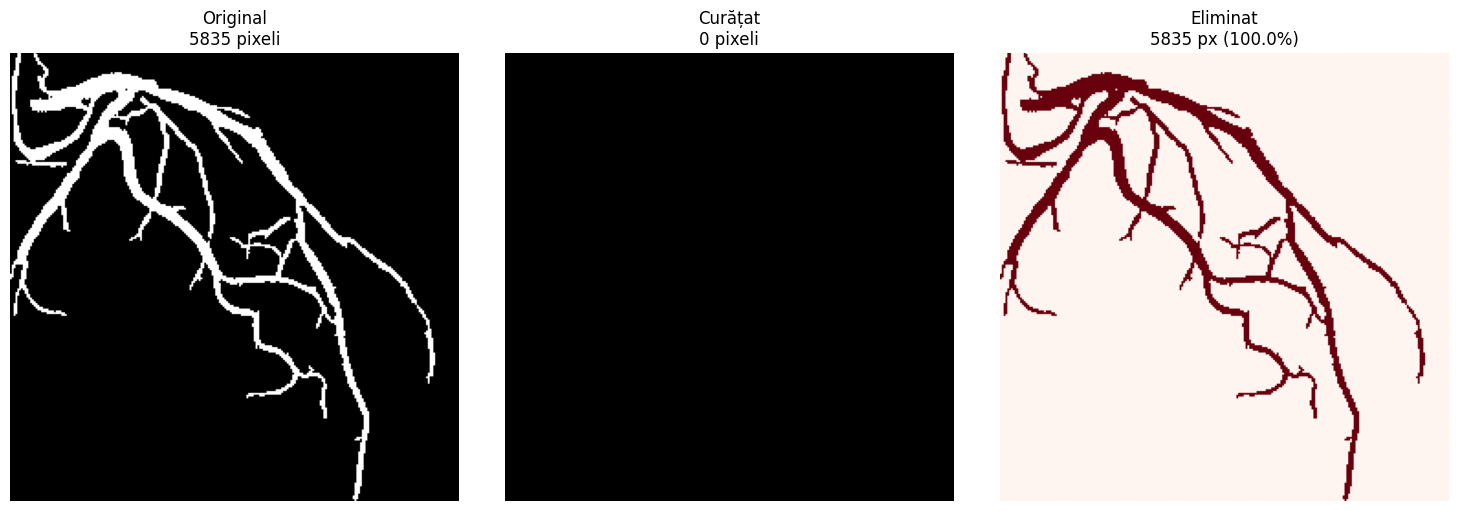

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from skimage.io import imread, imsave
from skimage.measure import label, regionprops
from skimage.morphology import disk, remove_small_objects

def _filter_linear_artifacts(mask):
    """Elimină cateterele (linii drepte lungi)."""
    labels = label(mask)
    for region in regionprops(labels):
        if region.eccentricity > 0.990 and region.area > 100:
            if region.minor_axis_length < 6:
                mask[labels == region.label] = False
    return mask

def _remove_border_artifacts_custom(mask, border_thickness=30, area_threshold=500):
    """Elimină AGRESIV componentele de pe marginile imaginii."""
    if mask.sum() == 0:
        return mask
    
    h, w = mask.shape
    labels = label(mask)
    if labels.max() == 0:
        return mask
        
    regions = regionprops(labels)
    output_mask = mask.copy()
    
    # Crează zonele de margine (3 niveluri de severitate)
    border_outer = np.zeros_like(mask, dtype=bool)
    border_outer[:border_thickness, :] = True
    border_outer[-border_thickness:, :] = True
    border_outer[:, :border_thickness] = True
    border_outer[:, -border_thickness:] = True
    
    # Zone mai stricte pentru margini
    strict_thickness = border_thickness // 2
    border_strict = np.zeros_like(mask, dtype=bool)
    border_strict[:strict_thickness, :] = True
    border_strict[-strict_thickness:, :] = True
    border_strict[:, :strict_thickness] = True
    border_strict[:, -strict_thickness:] = True
    
    for region in regions:
        minr, minc, maxr, maxc = region.bbox
        
        # Verifică dacă componenta atinge marginea imaginii
        touches_edge = (minr == 0 or minc == 0 or maxr == h or maxc == w)
        touches_border = (minr < border_thickness or 
                         minc < border_thickness or 
                         maxr > h - border_thickness or 
                         maxc > w - border_thickness)
        
        component_mask = (labels == region.label)
        border_pixels = (component_mask & border_outer).sum()
        strict_border_pixels = (component_mask & border_strict).sum()
        total_pixels = region.area
        border_ratio = border_pixels / total_pixels if total_pixels > 0 else 0
        strict_ratio = strict_border_pixels / total_pixels if total_pixels > 0 else 0
        
        should_remove = False
        
        # Condiție 1: Atinge marginea efectivă și este alungit (frame artifact)
        if touches_edge and region.eccentricity > 0.85:
            should_remove = True
        
        # Condiție 2: Peste 40% în zona de border și este alungit
        if border_ratio > 0.4 and region.eccentricity > 0.90:
            should_remove = True
        
        # Condiție 3: Componentă mică (< area_threshold) cu > 30% pe margine
        if region.area < area_threshold and border_ratio > 0.3:
            should_remove = True
        
        # Condiție 4: Orice componentă cu > 50% în border strict (foarte pe margine)
        if strict_ratio > 0.5:
            should_remove = True
        
        # Condiție 5: Componentă foarte pe margine (> 70% în border zone)
        if border_ratio > 0.7:
            should_remove = True
        
        # Condiție 6: Componente înguste pe margini (framuri)
        if touches_border and region.minor_axis_length < 15 and region.area > 200:
            should_remove = True
        
        # Condiție 7: Componente care ocupă doar corners
        if touches_edge:
            # Verifică dacă este în colț (primii/ultimii pixels pe ambele direcții)
            in_corner = ((minr < border_thickness and minc < border_thickness) or
                        (minr < border_thickness and maxc > w - border_thickness) or
                        (maxr > h - border_thickness and minc < border_thickness) or
                        (maxr > h - border_thickness and maxc > w - border_thickness))
            if in_corner and region.area < 1000:
                should_remove = True
        
        if should_remove:
            output_mask[labels == region.label] = False
    
    return output_mask

def _keep_largest_vessel_tree_custom(mask, min_ratio=0.15):
    """Păstrează doar arborele vascular principal."""
    mask_clean = remove_small_objects(mask, min_size=50)
    labels = label(mask_clean)
    
    if labels.max() == 0:
        return mask_clean
        
    regions = regionprops(labels)
    regions.sort(key=lambda x: x.area, reverse=True)
    
    output = np.zeros_like(mask, dtype=bool)
    
    if len(regions) > 0:
        output[labels == regions[0].label] = True
        
        for i in range(1, min(len(regions), 4)):
            if regions[i].area > regions[0].area * min_ratio:
                output[labels == regions[i].label] = True
            
    return output

def clean_existing_masks(input_dir, output_dir, 
                         border_thickness=30, 
                         area_threshold=500,
                         min_tree_ratio=0.15,
                         visualize=True):
    """
    Procesează măștile binare existente și le curăță de artefacte de margine.
    
    Args:
        input_dir: Directorul cu măștile originale (PNG/NPY)
        output_dir: Directorul unde se salvează măștile curățate
        border_thickness: Grosimea zonei de margine (pixeli)
        area_threshold: Prag pentru componente mici pe margine
        min_tree_ratio: Raportul minim pentru componente secundare (față de principala)
        visualize: Dacă True, salvează și comparația vizuală
    
    Returns:
        Numărul de măști procesate
    """
    os.makedirs(output_dir, exist_ok=True)
    if visualize:
        os.makedirs(os.path.join(output_dir, "comparisons"), exist_ok=True)
    
    # Găsește toate fișierele de mască
    mask_files = []
    for ext in ['*.png', '*.npy', '*.jpg', '*.tif']:
        mask_files.extend(glob.glob(os.path.join(input_dir, ext)))
    
    if len(mask_files) == 0:
        print(f"⚠️  Nu s-au găsit măști în {input_dir}")
        return 0
    
    print(f"🔍 Găsite {len(mask_files)} măști în {input_dir}")
    print(f"📊 Parametri: border={border_thickness}px, area_thresh={area_threshold}, tree_ratio={min_tree_ratio}")
    print("-" * 60)
    
    processed_count = 0
    
    for i, mask_path in enumerate(mask_files):
        filename = os.path.basename(mask_path)
        name_without_ext = os.path.splitext(filename)[0]
        
        # Încarcă masca
        if mask_path.endswith('.npy'):
            mask_original = np.load(mask_path)
        else:
            mask_original = imread(mask_path)
            # Convertește la binar dacă e necesar
            if mask_original.ndim == 3:
                mask_original = mask_original[:, :, 0]
            if mask_original.dtype == np.uint8:
                mask_original = mask_original > 127
            else:
                mask_original = mask_original > 0.5
        
        # Asigură-te că e boolean
        mask_original = mask_original.astype(bool)
        
        pixels_before = mask_original.sum()
        
        # Aplică filtrele de curățare
        mask_clean = mask_original.copy()
        
        # 1. Elimină artefacte liniare
        mask_clean = _filter_linear_artifacts(mask_clean)
        
        # 2. Elimină componentele de pe margini (AGRESIV)
        mask_clean_temp = _remove_border_artifacts_custom(
            mask_clean, 
            border_thickness=border_thickness,
            area_threshold=area_threshold
        )
        
        # 3. Păstrează arborele principal
        mask_clean_final = _keep_largest_vessel_tree_custom(
            mask_clean_temp,
            min_ratio=min_tree_ratio
        )
        
        pixels_after = mask_clean_final.sum()
        pixels_removed = pixels_before - pixels_after
        removal_percent = (pixels_removed / pixels_before * 100) if pixels_before > 0 else 0
        
        # Salvează masca curățată
        output_path = os.path.join(output_dir, f"{name_without_ext}_clean.png")
        imsave(output_path, (mask_clean_final * 255).astype(np.uint8))
        
        # Vizualizare comparație
        if visualize:
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))
            
            axes[0].imshow(mask_original, cmap='gray')
            axes[0].set_title(f"Original\n{pixels_before} pixeli")
            axes[0].axis('off')
            
            axes[1].imshow(mask_clean_final, cmap='gray')
            axes[1].set_title(f"Curățat\n{pixels_after} pixeli")
            axes[1].axis('off')
            
            # Diferență (ce s-a eliminat)
            diff = mask_original.astype(int) - mask_clean_final.astype(int)
            axes[2].imshow(diff, cmap='Reds', vmin=0, vmax=1)
            axes[2].set_title(f"Eliminat\n{pixels_removed} px ({removal_percent:.1f}%)")
            axes[2].axis('off')
            
            plt.tight_layout()
            comparison_path = os.path.join(output_dir, "comparisons", f"{name_without_ext}_comparison.png")
            plt.savefig(comparison_path, bbox_inches='tight', dpi=100)
            plt.close(fig)
        
        processed_count += 1
        print(f"✅ [{i+1}/{len(mask_files)}] {filename}: "
              f"{pixels_before} → {pixels_after} pixeli (-{removal_percent:.1f}%)")
    
    print("-" * 60)
    print(f"✨ Procesare completă! {processed_count} măști curățate în {output_dir}")
    return processed_count


# Exemplu de utilizare:
clean_existing_masks(
    input_dir="vasomim_masks_only",
    output_dir="vasomim_masks_clean",
    border_thickness=30,
    area_threshold=500,
    visualize=True
)